# Create maps showing average IMD for each IVT unit catchment

Using the datafile as created from notebook 02_combine_demographic_data.ipynb, create maps of IMD for each IVT unit, showing the weighted population average.

To help with geopandas use https://github.com/MichaelAllen1966/2010_geopandas/blob/main/geopandas_1.ipynb

Import libraries

In [29]:
import numpy as np
import pandas as pd
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt

Read in Index of Multiple Deprivation data (per LSOA)

In [30]:
df_lsoa = pd.read_csv('./data/collated_data.csv')
#df_lsoa.set_index(['LSOA'], inplace=True)

Look at first few rows

In [31]:
df_lsoa.head()

,LSOA,admissions,closest_ivt_unit,closest_ivt_time,closest_mt_unit,closest_mt_time,mt_transfer_time,ivt_rate,Local Authority District name (2019),Income Domain Score,...,age band males 50,age band males 55,age band males 60,age band males 65,age band males 70,age band males 75,age band males 80,age band males 85,age band males 90,age band males 95
0,Welwyn Hatfield 010F,0.666667,SG14AB,19.2,NW12BU,37.5,47.2,6.8,Welwyn Hatfield,0.104,...,53.0,62.0,37.0,32.0,27.0,30.0,15.0,4.0,3.0,0.0
1,Welwyn Hatfield 012A,4.000000,SG14AB,20.3,NW12BU,37.5,47.2,6.8,Welwyn Hatfield,0.176,...,58.0,63.0,43.0,36.0,25.0,14.0,15.0,9.0,7.0,0.0
2,Welwyn Hatfield 002F,2.000000,SG14AB,19.2,NW12BU,38.6,47.2,6.8,Welwyn Hatfield,0.037,...,43.0,50.0,51.0,21.0,31.0,8.0,5.0,8.0,5.0,0.0
3,Welwyn Hatfield 002E,0.666667,SG14AB,19.2,NW12BU,37.5,47.2,6.8,Welwyn Hatfield,0.066,...,42.0,63.0,33.0,20.0,15.0,18.0,18.0,5.0,1.0,0.0
4,Welwyn Hatfield 010A,3.333333,SG14AB,19.2,NW12BU,37.5,47.2,6.8,Welwyn Hatfield,0.113,...,56.0,54.0,37.0,32.0,28.0,21.0,12.0,9.0,2.0,0.0


Group data by "closest_ivt_unit" and calculate the weighted average of IMD (weighted by population).

NOTE: Couldn't find IMD in dataset, so for now using "Income Domain Score", and will check what to use later.

https://stackoverflow.com/questions/31521027/groupby-weighted-average-and-sum-in-pandas-dataframe

In [32]:
# Define a lambda function to compute the weighted mean:
wm = lambda x: np.average(x, weights=df_lsoa.loc[x.index, "All persons"])

# Define a dictionary with the functions to apply for a given column:
# the following is deprecated since pandas 0.20:
# f = {'adjusted_lots': ['sum'], 'price': {'weighted_mean' : wm} }
# df.groupby(["contract", "month", "year", "buys"]).agg(f)

# Groupby and aggregate with namedAgg [1]:
ivt_imd = df_lsoa.groupby(["closest_ivt_unit"]).agg(
            all_persons=("All persons", "sum"),  
            income_domain_score_weighted_mean=("Income Domain Score", wm))
ivt_imd

,all_persons,income_domain_score_weighted_mean
closest_ivt_unit,,
B152TH,946192.0,0.182013
B714HJ,950166.0,0.200384
BA13NG,481727.0,0.084326
BA214AT,284415.0,0.094389
BB23HH,491561.0,0.177081
...,...,...
WD180HB,609652.0,0.082740
WF14DG,597452.0,0.148566
WR51DD,406174.0,0.094492


Map the data.

Load LSOA shape file

The following will load the shape file of the South West of England LSOA (Lower Super Output Areas) into a GeoPandas DataFrame. Note that we can set the crs (Coordinate Reference System) when loading a GeoPandas DataFrame. EPSG:27700 is the crs to use when geography is in BNG (British National Grid Eastings and Northings).

EPSG:27700 OSGB 1936 / British National Grid -- United Kingdom Ordnance Survey. Co-ordinates are in Eastings (X) and Northings (Y).
EPSG:4326 WGS 84 -- WGS84 - World Geodetic System 1984. Co-ordinates are in Longitude (X) and Latitude (Y).
EPSG:3857 - projection for displaying lat/long as a flat map

In [33]:
#filename = 'zip://./data/Lower_Layer_Super_Output_Areas_December_2011_Full_Clipped__Boundaries_in_England_and_Wales.zip'
filename = 'zip://./data/Lower_layer_super_output_areas_(E+W)_2011_Boundaries_(Generalised_Clipped)_V2.zip'
gdf_lsoa = gpd.read_file(filename, crs='EPSG:27700')

In [34]:
gdf_lsoa.head()

,LSOA11CD,LSOA11NM,LSOA11NMW,geometry
0,E01000001,City of London 001A,City of London 001A,"POLYGON ((532105.092 182011.230, 532162.491 18..."
1,E01000002,City of London 001B,City of London 001B,"POLYGON ((532746.813 181786.891, 532671.688 18..."
2,E01000003,City of London 001C,City of London 001C,"POLYGON ((532135.145 182198.119, 532158.250 18..."
3,E01000005,City of London 001E,City of London 001E,"POLYGON ((533807.946 180767.770, 533649.063 18..."
4,E01000006,Barking and Dagenham 016A,Barking and Dagenham 016A,"POLYGON ((545122.049 184314.931, 545271.917 18..."


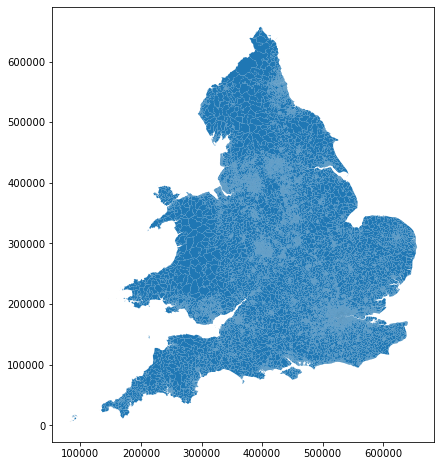

In [35]:
gdf_lsoa.plot(figsize=(8,8));

Merging areas together
Now we are going to merge LSOAs that are in the same IVT unit catchment (we can merge on any column in order to combine areas). This will create a new DataFrame. To merge areas we use the dissolve() method.

https://geopandas.org/aggregation_with_dissolve.html

But first need to add a column to the geopandas dataframe. Using LSOA as the common value, bring in the field 'closest_ivt_unit'

Match lsoa_gdf['LSOA11NMW'] with lsoa_df['LSOA'] and add lsoa_df['closest_ivt_unit'] to lsoa_gdf['closest_ivt_unit'].
https://stackoverflow.com/questions/39816671/pandas-populate-new-dataframe-column-based-on-matching-columns-in-another-datafr

In [36]:
#gdf_lsoa.join(df_lsoa['closest_ivt_unit','LSOA'].set_index('LSOA'), on='LSOA11NMW')
#gdf_lsoa.head()

In [37]:
df_lsoa.set_index(['LSOA'], inplace=True)
gdf_lsoa.set_index(['LSOA11NMW'], inplace=True)

gdf_lsoa = gdf_lsoa.join(df_lsoa['closest_ivt_unit']).reset_index()
gdf_lsoa.head()


,LSOA11NMW,LSOA11CD,LSOA11NM,geometry,closest_ivt_unit
0,City of London 001A,E01000001,City of London 001A,"POLYGON ((532105.092 182011.230, 532162.491 18...",E11BB
1,City of London 001B,E01000002,City of London 001B,"POLYGON ((532746.813 181786.891, 532671.688 18...",E11BB
2,City of London 001C,E01000003,City of London 001C,"POLYGON ((532135.145 182198.119, 532158.250 18...",E11BB
3,City of London 001E,E01000005,City of London 001E,"POLYGON ((533807.946 180767.770, 533649.063 18...",E11BB
4,Barking and Dagenham 016A,E01000006,Barking and Dagenham 016A,"POLYGON ((545122.049 184314.931, 545271.917 18...",RM70AG


In [38]:
ivt_catchment_gdf = gdf_lsoa.dissolve(by='closest_ivt_unit')
ivt_catchment_gdf

,geometry,LSOA11NMW,LSOA11CD,LSOA11NM
closest_ivt_unit,,,,
B152TH,"MULTIPOLYGON (((416409.188 268044.406, 416406....",Birmingham 067A,E01008881,Birmingham 067A
B714HJ,"MULTIPOLYGON (((417821.448 275919.567, 417832....",Birmingham 037A,E01008899,Birmingham 037A
BA13NG,"MULTIPOLYGON (((390339.219 149073.312, 390339....",Bath and North East Somerset 007A,E01014370,Bath and North East Somerset 007A
BA214AT,"MULTIPOLYGON (((325347.501 91556.700, 325347.4...",East Devon 005A,E01019886,East Devon 005A
BB23HH,"MULTIPOLYGON (((378922.528 421439.886, 379017....",Bolton 001B,E01004803,Bolton 001B
...,...,...,...,...
WD180HB,"MULTIPOLYGON (((510268.481 190635.984, 510268....",Barnet 003A,E01000166,Barnet 003A
WF14DG,"MULTIPOLYGON (((435708.098 405685.733, 435707....",Barnsley 018C,E01007320,Barnsley 018C
WR51DD,"MULTIPOLYGON (((390367.310 234024.700, 390550....",Herefordshire 005A,E01014000,Herefordshire 005A


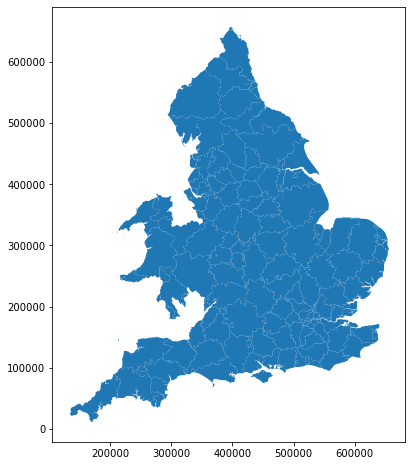

In [39]:
ivt_catchment_gdf.plot(figsize=(8,8));

Add data about IMD, joining based on 'closest_ivt_unit'

In [41]:
#ivt_catchment_gdf.set_index(['closest_ivt_unit'], inplace=True)
ivt_catchment_gdf = ivt_catchment_gdf.join(ivt_imd['income_domain_score_weighted_mean']).reset_index()
ivt_catchment_gdf.head()

,closest_ivt_unit,geometry,LSOA11NMW,LSOA11CD,LSOA11NM,income_domain_score_weighted_mean
0,B152TH,"MULTIPOLYGON (((416409.188 268044.406, 416406....",Birmingham 067A,E01008881,Birmingham 067A,0.182013
1,B714HJ,"MULTIPOLYGON (((417821.448 275919.567, 417832....",Birmingham 037A,E01008899,Birmingham 037A,0.200384
2,BA13NG,"MULTIPOLYGON (((390339.219 149073.312, 390339....",Bath and North East Somerset 007A,E01014370,Bath and North East Somerset 007A,0.084326
3,BA214AT,"MULTIPOLYGON (((325347.501 91556.700, 325347.4...",East Devon 005A,E01019886,East Devon 005A,0.094389
4,BB23HH,"MULTIPOLYGON (((378922.528 421439.886, 379017....",Bolton 001B,E01004803,Bolton 001B,0.177081


Mapping data with MatPlotLib

Using MatPlotLib gives us more power than the GeoPandas DataFrame plot method.

To do: 
1. Add hospital location.
2. Check what value to plot. Is 'Income Domain Score' the right thing (couldn't find IMD in the dataset)?

In [44]:
# When using base maps convert data to epsg:3857
ivt_catchment_gdf = ivt_catchment_gdf.to_crs(epsg=3857)

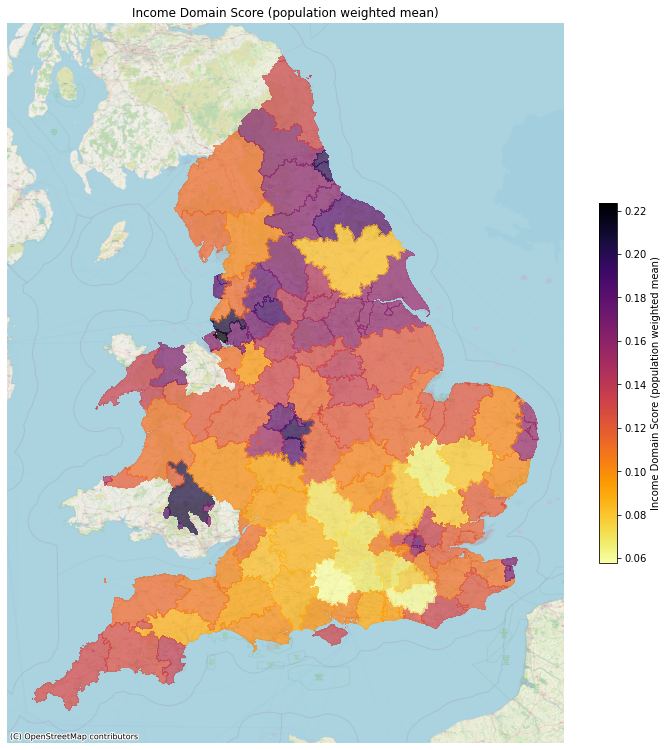

In [46]:
col = 'income_domain_score_weighted_mean'
col_readable = 'Income Domain Score (population weighted mean)'

fig, ax = plt.subplots(figsize=(10, 10)) # Make max dimensions 10x10 inch
ivt_catchment_gdf.plot(ax=ax, # Set which axes to use for plot (only one here)
                 column=col, # Column to apply colour
                 antialiased=False, # Avoids artifact boundry lines
                 edgecolor='face', # Make LSOA boundry same colour as area
                 linewidth=0.0,# Use linewidth=0 to hide boarder lines
#                 vmin=0, # Manual scale min (remove to make automatic)
#                 vmax=70, # Manual scale max (remove to make automatic)
                 cmap='inferno_r', # Colour map to use
                 # Adjust size of colourmap key, and add label
                 legend_kwds={'shrink':0.5, 'label':f'{col_readable}'},
                 # Set to display legend
                 legend=True,
                 # Set transparancy (to help reveal basemap
                 alpha = 0.70)

# Add base map (note that we specifiy thr same CRS as we are using)
# Use manual zoom to adjust level of detail of base map
ctx.add_basemap(ax, 
                source=ctx.providers.OpenStreetMap.Mapnik,zoom=10)

ax.set_axis_off() # Turn of axis line and numbers
ax.set_title(f'{col_readable}')
# Adjust for printing
ax.margins(0)
ax.apply_aspect()
plt.subplots_adjust(left=0.01, right=1.0, bottom=0.0, top=1.0)
plt.savefig(f'map_{col}.jpg', dpi=300) # Save figure
plt.show()